# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

from preprocessing import *
from math_utils import *
from plotting import *

%matplotlib inline

rcParams['figure.figsize'] = 12, 6

IMAGES_PATH = 'train-images-idx3-ubyte'
LABELS_PATH = 'train-labels-idx1-ubyte'
RANDOM_SEED = 42

N_FEATURES = 28 * 28
N_CLASSES = 10

# Splitting the data

In [2]:
X, y = read_mnist(IMAGES_PATH, LABELS_PATH)
X, y = shuffle_data(X, y, random_seed=RANDOM_SEED)
X_train, y_train = X[:500], y[:500]
X_test, y_test = X[500:], y[500:]

# Data exploration

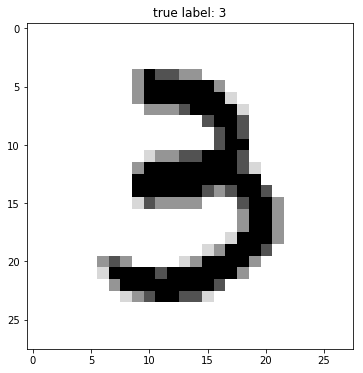

In [3]:
plot_digit(X, y, idx=1)

# Building our model

In [4]:
class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30,
                 l1=0.0, l2=0.0, epochs=500, learning_rate=0.01,
                 n_batches=1, random_seed=None):

        if random_seed:
            np.random.seed(random_seed)
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.w1, self.w2 = self._init_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_batches = n_batches

    def _init_weights(self):
        w1 = np.random.uniform(-1.0, 1.0, 
                               size=self.n_hidden_units * (self.n_features + 1))
        w1 = w1.reshape(self.n_hidden_units, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0, 
                               size=self.n_classes * (self.n_hidden_units + 1))
        w2 = w2.reshape(self.n_classes, self.n_hidden_units + 1)
        return w1, w2

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('how must be columns or row')
        return X_new

    def _forward(self, X):
        net_input = self._add_bias_unit(X, how='column')
        net_hidden = self.w1.dot(net_input.T)
        act_hidden = sigmoid(net_hidden)
        act_hidden = self._add_bias_unit(act_hidden, how='row')
        net_out = self.w2.dot(act_hidden)
        act_out = sigmoid(net_out)
        return net_input, net_hidden, act_hidden, net_out, act_out
    
    def _backward(self, net_input, net_hidden, act_hidden, act_out, y):
        sigma3 = act_out - y
        net_hidden = self._add_bias_unit(net_hidden, how='row')
        sigma2 = self.w2.T.dot(sigma3) * sigmoid_prime(net_hidden)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(net_input)
        grad2 = sigma3.dot(act_hidden.T)
        return grad1, grad2

    def _error(self, y, output):
        L1_term = L1_reg(self.l1, self.w1, self.w2)
        L2_term = L2_reg(self.l2, self.w1, self.w2)
        error = cross_entropy(output, y) + L1_term + L2_term
        return 0.5 * np.mean(error)

    def _backprop_step(self, X, y):
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(X)
        y = y.T

        grad1, grad2 = self._backward(net_input, net_hidden, act_hidden, act_out, y)

        # regularize
        grad1[:, 1:] += (self.w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (self.w2[:, 1:] * (self.l1 + self.l2))

        error = self._error(y, act_out)
        
        return error, grad1, grad2

    def predict(self, X):
        Xt = X.copy()
        a1, z2, a2, z3, a3 = self._forward(Xt)
        return mle(z3.T)
    
    def predict_proba(self, X):
        a1, z2, a2, z3, a3 = self._forward(X)
        return softmax(a3.T)

    def fit(self, X, y):
        self.error_ = []
        X_data, y_data = X.copy(), y.copy()
        y_data_enc = one_hot(y_data, self.n_classes)
        for i in range(self.epochs):

            X_mb = np.array_split(X_data, self.n_batches)
            y_mb = np.array_split(y_data_enc, self.n_batches)

            for Xi, yi in zip(X_mb, y_mb):
                
                # update weights
                error, grad1, grad2 = self._backprop_step(Xi, yi)
                self.error_.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)

        return self
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

## Training

In [5]:
nn = NNClassifier(n_classes=N_CLASSES, 
                  n_features=N_FEATURES,
                  n_hidden_units=50,
                  l2=0.5,
                  l1=0.0,
                  epochs=300,
                  learning_rate=0.001,
                  n_batches=25,
                  random_seed=RANDOM_SEED)

nn.fit(X_train, y_train);

# Evaluation

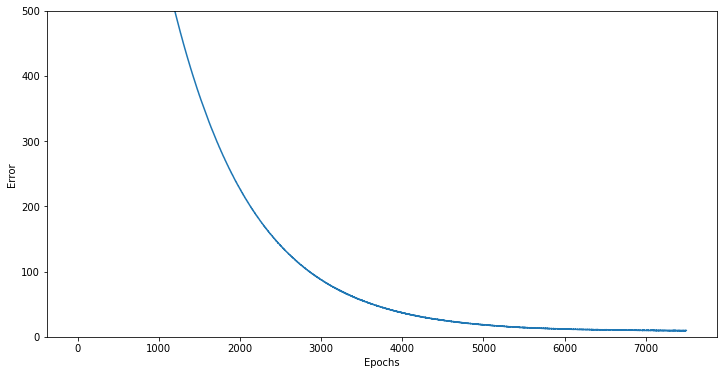

In [6]:
plot_error(nn)

In [7]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Train Accuracy: 93.20%
Test Accuracy: 81.61%


In [8]:
nn.predict_proba(X_test[1:2])

array([[ 0.08791506,  0.08967695,  0.09230137,  0.08762937,  0.08983014,
         0.08973725,  0.18280843,  0.08709262,  0.10326369,  0.08974513]])

## Correct prediction

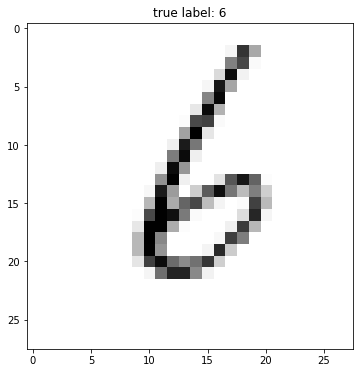

In [9]:
plot_digit(X_test, y_test, idx=1)

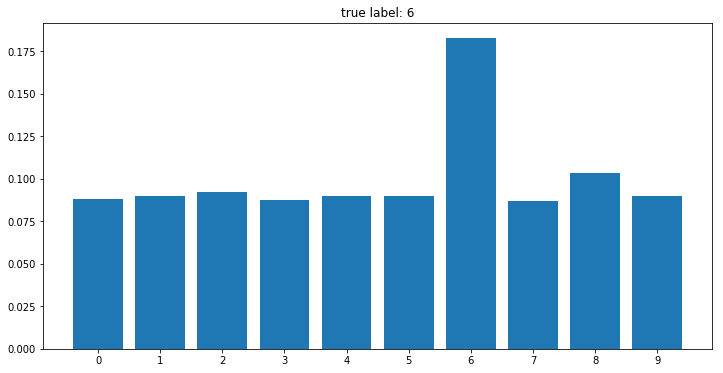

In [10]:
plot_digit_dist(X_test, y_test, idx=1, model=nn)

## Wrong prediction

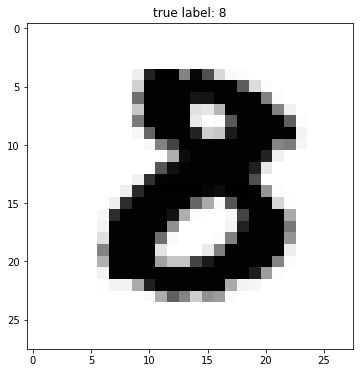

In [11]:
plot_digit(X_test, y_test, idx=25)

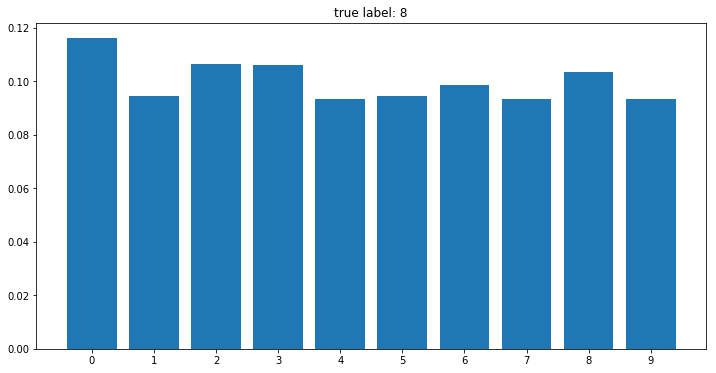

In [12]:
plot_digit_dist(X_test, y_test, idx=25, model=nn)

## MLE = picking the most probable digit

In [13]:
nn.predict_proba(X_test[:5])

array([[ 0.08608564,  0.17233102,  0.09845582,  0.09196923,  0.0884549 ,
         0.08626702,  0.08759334,  0.08866887,  0.11129755,  0.0888766 ],
       [ 0.08791506,  0.08967695,  0.09230137,  0.08762937,  0.08983014,
         0.08973725,  0.18280843,  0.08709262,  0.10326369,  0.08974513],
       [ 0.08669851,  0.19451022,  0.09157125,  0.09088218,  0.08784206,
         0.08789407,  0.08887273,  0.08918729,  0.09193998,  0.09060171],
       [ 0.18322969,  0.08823892,  0.0932458 ,  0.09058121,  0.08891085,
         0.09267016,  0.09125112,  0.0901729 ,  0.0904505 ,  0.09124884],
       [ 0.08696752,  0.08800426,  0.08603436,  0.08992187,  0.09368129,
         0.19789774,  0.08758577,  0.08882118,  0.09050277,  0.09058323]])

In [14]:
mle(nn.predict_proba(X_test[:5]))

array([1, 6, 1, 0, 5])

In [15]:
nn.predict(X_test[:5])

array([1, 6, 1, 0, 5])